# This notebook is for Analyzing Enron Email Dataset

## Tasks to Do

1. Select emails base on keywords 
    1. Load, Clean & Parse Emails to get started
    2. Select emails based on keywords
2. Time series analysis of the emails
    1. Parse string to Datetime object for doing time series analysis
    2. Plot time series
3. Email Clustering
    1. Rremoving stopwords and vectorize the content
    2. Run KMeans on the Data
    3. Find important keywords from for each clusters
    4. Find topics from the text (??)
4. Sentiment Analysis
    1. Do Sentiment analysis on the email texts
    2. plot sentiments 


#### Importing modules

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans, MiniBatchKMeans
import re

from parse_utils import parse_raw_message, parse_into_emails, parse_raw_message
from plot_utils import top_mean_feats, top_feats_per_cluster, plot_tfidf_classfeats_h
plt.rcParams["figure.figsize"] = (20,8) #Setting global parameters for plots


#### Reading Data from the directory

In [2]:
project_email_df = pd.read_csv('processed_data/parsed_emails.csv')


#### Parsing Date String to (yyyy-mm-dd hh:mm:ss)

In [3]:
# Sample for parsing
datetime_object = datetime.strptime('Thu, 31 Aug 2000 05', '%a, %d %b %Y %H')
print(datetime_object)

2000-08-31 05:00:00


In [4]:
def parse_date(row):
    date_str = row['date']
    try:
        datetime_object = datetime.strptime(date_str, '%a, %d %b %Y %H')
    except:
        return None
    return datetime_object

In [5]:
#Parsing dates for all emails
project_email_df['date_converted'] = project_email_df.apply(parse_date, axis = 1)

In [6]:
#Ignore emails that failed in date conversion
project_email_df.dropna(inplace =True)

In [7]:
#Sample of Date Conversion
project_email_df['date_converted']

0       2000-10-09 07:00:00
1       2000-10-03 09:00:00
2       2000-09-26 09:00:00
4       2000-09-19 09:00:00
5       2000-09-11 09:00:00
                ...        
12113   2001-08-06 11:00:00
12114   2001-06-29 08:00:00
12115   2001-06-25 07:00:00
12116   2001-06-20 14:00:00
12117   2001-12-11 09:00:00
Name: date_converted, Length: 10902, dtype: datetime64[ns]

<AxesSubplot:xlabel='date_converted'>

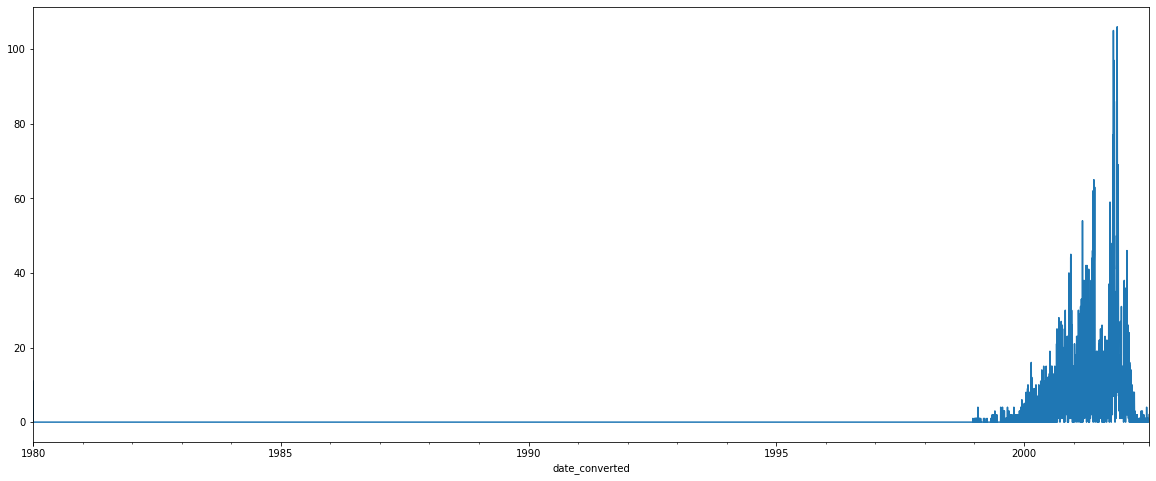

In [8]:
# Email Timelines (change the parameter in the last line to get timeline datewise (D), monthwise (M), yearwise (Y))
plt.rcParams["figure.figsize"] = (20,8)
project_email_df = project_email_df.set_index('date_converted') 
project_email_df.sort_index(inplace = True)
project_email_df.groupby(pd.Grouper(freq='D')).size().plot()

In [9]:
# Select Emails after the year 2000 to get a nice plot
project_email_df['parsed_date'] = project_email_df.index
mask = project_email_df['parsed_date'] > '2000-01-01'
project_email_df = project_email_df.loc[mask]

<AxesSubplot:xlabel='date_converted'>

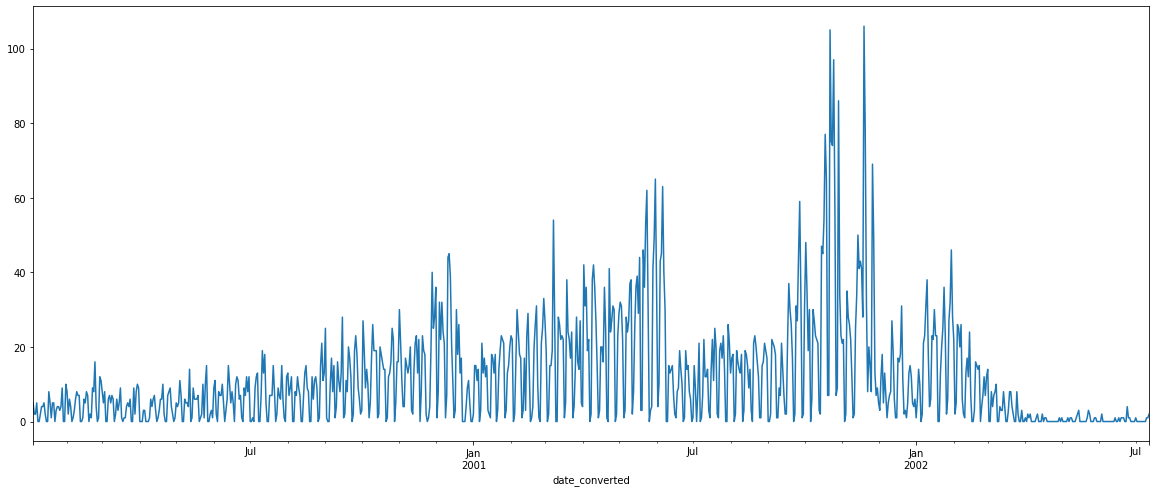

In [10]:

project_email_df.groupby(pd.Grouper(freq='D')).size().plot()

## Cluster Emails 

In [11]:
# Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)

X = vect.fit_transform(project_email_df.body)
features = vect.get_feature_names()

In [12]:
n_clusters = 7
batch_size = 500
clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
clf.fit(X)
labels = clf.fit_predict(X)


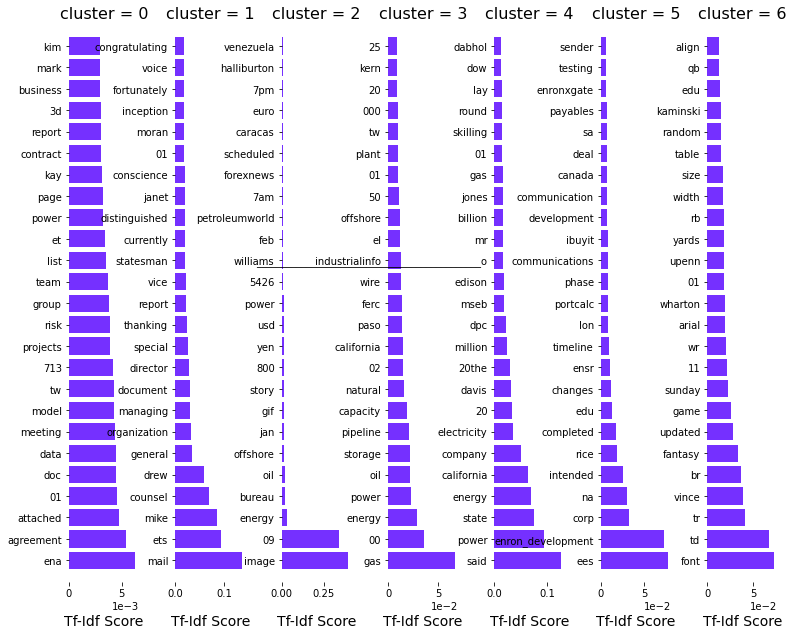

In [13]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


### Sentiment Analysis

In [14]:
sentiments = []
bodies = []
dates = []
for index, row in project_email_df.iterrows():
    body = row['body']
    bodies.append(body)
    opinion = TextBlob(body)
    pol, sent = opinion.sentiment
    if sent < 0.7:
        continue
    sentiments.append(sent)
    dates.append(row['parsed_date'])

Text(0, 0.5, 'Sentiment')

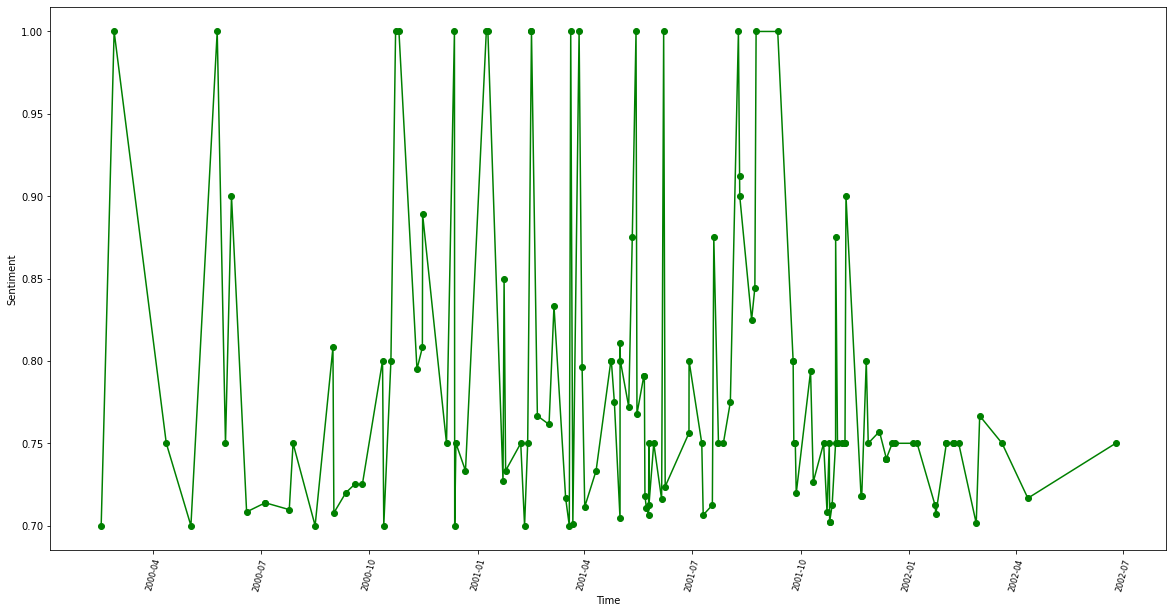

In [15]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(rotation=75, fontsize=8)
ax.plot(dates, sentiments, marker='o', color = 'green' )

plt.xlabel('Time')
plt.ylabel('Sentiment')

In [16]:
count = 0
for sentiment, body, date in zip(sentiments, bodies, dates):
    if sentiment > 0.95:
        print(body)
        print('\n' * 2)
        count += 1
        if count == 10:
            break
        
        

candace , sorry for the delay . i shall edit the job description and forward it to youlater today . vincecandace womack<rvanraven@ix . netcom . com> , margaret daffin/hou/ect@ect , janeallen/hou/ect@ectvince - will you please review the following job description which tindall &foster has prepared , and edit it as needed for vincent tang's position ? we need this job description in order to proceed with the other stepsnecessary in obtaining vincent's green card . please feel free to call me if you have any questions regarding this . thanks . candacex30651---------------------- forwarded by candace womack/hou/ect on 01/04/2000i still do not have a job description for vincent's position . maybeenron does not have one ? candace , here is a sample job description . please check with vincent'ssupervisor on modifying this for the job description . this was my bestguess , but i may be way off . . . if so , we have many other genericexamples to use instead . just let me know . operations resear

In [17]:
print(len(bodies), len(set(bodies)))

10697 10697
